## VIMS_alpOri271I_analysis_v2.ipynb

Richard G. French, Wellesley College

This Jupyter notebook contains an analysis of the Cassini VIMS observations of the alpOri271 occultation, using data provided by An Foster and Phil Nicholson.

The following steps are performed:

1) Perform model fits to the observations:
    isothermal fits
    isothermal + absorption model based on Goody random band model
2) Overplot Phil Nicholson's model predictions
3) Perform numerical inversion of observations to derive T(P) profile
4) Compare retrieved T(P) with CIRS observations
5) Construct synthetic lightcurve based on CIRS T(P) and compare with observations
6) Perform end-to-end test of inverting the synthetic lightcurve to show that it matches input T(P)

This is a non-interactive notebook - simply run all cells
All required Python packages and data files are defined in the first code cell
All individual functions and procedures are in separate cells, with a description of the purpose and method of each.
The final cells perform the numbered steps above.

Revisions:

v2:

    2023 Oct 10 - rfrench - Move all routines to top, retain tests for documentation, but start new section

Liens:

1. g(r) not implemented - assumed to be constant over range of inversion (easy to fix)



In [1]:
# Load Python packages (ALL required dependencies are collected here)

from astropy import units as u
import astropy.constants as const
import csv
from lmfit import Parameters,minimize, fit_report
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.io import readsav # for IDL savefiles
from scipy.optimize import fsolve
from scipy.special import erfc # erfc for isothermal cap
import spiceypy as spice
from pentagram import *

# specify paths to required data files, and define VIMS dictionary with event information

path2inputfiles = './' # modify this to point to directory containing datafiles
path2kernels = './' # modify this to point to directory containing leapseconds kernel file
path2outputfiles = './output/' # modify this to point to directory containing datafiles
if not os.path.exists(path2outputfiles): # create the output directory if it doesn't exist
   os.makedirs(path2outputfiles)

VIMS_observed_lightcurve = 'lightcurvewithgoodbaseline.csv' # from An Foster
VIMS_isothermal_model = 'nicholso-isothermal-alpori271.out' # Phil Nicholson isothermal model
VIMS_isothermal_metadata = 'nicholso-isothermal-metadata-alpori271.out' # ... and metadata for documentation
tlsfile = 'naif0012.tls'

CIRS_TPprofiles = 'globaltemp.sav' # IDL savefile containing CIRS T(P) profiles as function of JD and latitude
# (Obtained from PDS Atmos node? not sure of origin)

# define VIMS dictionary containing essential event geometry and information

VIMS = {
    'path2inputfiles':path2inputfiles,
    'path2outputfiles':path2outputfiles,
    'path2kernels':path2kernels,
    'VIMS_observed_lightcurve':VIMS_observed_lightcurve,
    'dtsec':1.68, # from An Foster
    'VIMS_isothermal_model':VIMS_isothermal_model,
    'VIMS_isothermal_metadata':VIMS_isothermal_metadata,
    'tlsfile':tlsfile, 
    'CIRS_TPprofiles':CIRS_TPprofiles,
    'event':'VIMS alpOri271I',
    'UTC':"2017-116T21:20", #approximate only - used only to determine JD of event for CIRS T(P)
    'g_ms2':11.90*u.m/u.s**2, # from PDN
    'H_km':44.*u.km, # from An 
    'half-light':930, # frame number, from metadata file...
    't_cube':1.68*u.s, 
    't_pixel':0.021*u.s, 
    'rc':54914.3*u.km, 
    'vperp':-2.311*u.km/u.s, 
    'lat_c':-74.44*u.deg,
    'lat_g':-77.23*u.deg,
    'time':1566.6*u.s,
    'range':6.8726e+05*u.km, 
    'alpha':-66.36*u.deg, 
    'r_curv':66043.5*u.km,
    'mu':2.2* u.g/u.mol, # from PDN 
    'RSTP': 129.e-6 # refractivity at STP
}

# All defs loaded first

# Load data, plot and perform isothermal and iso-tau band model fits

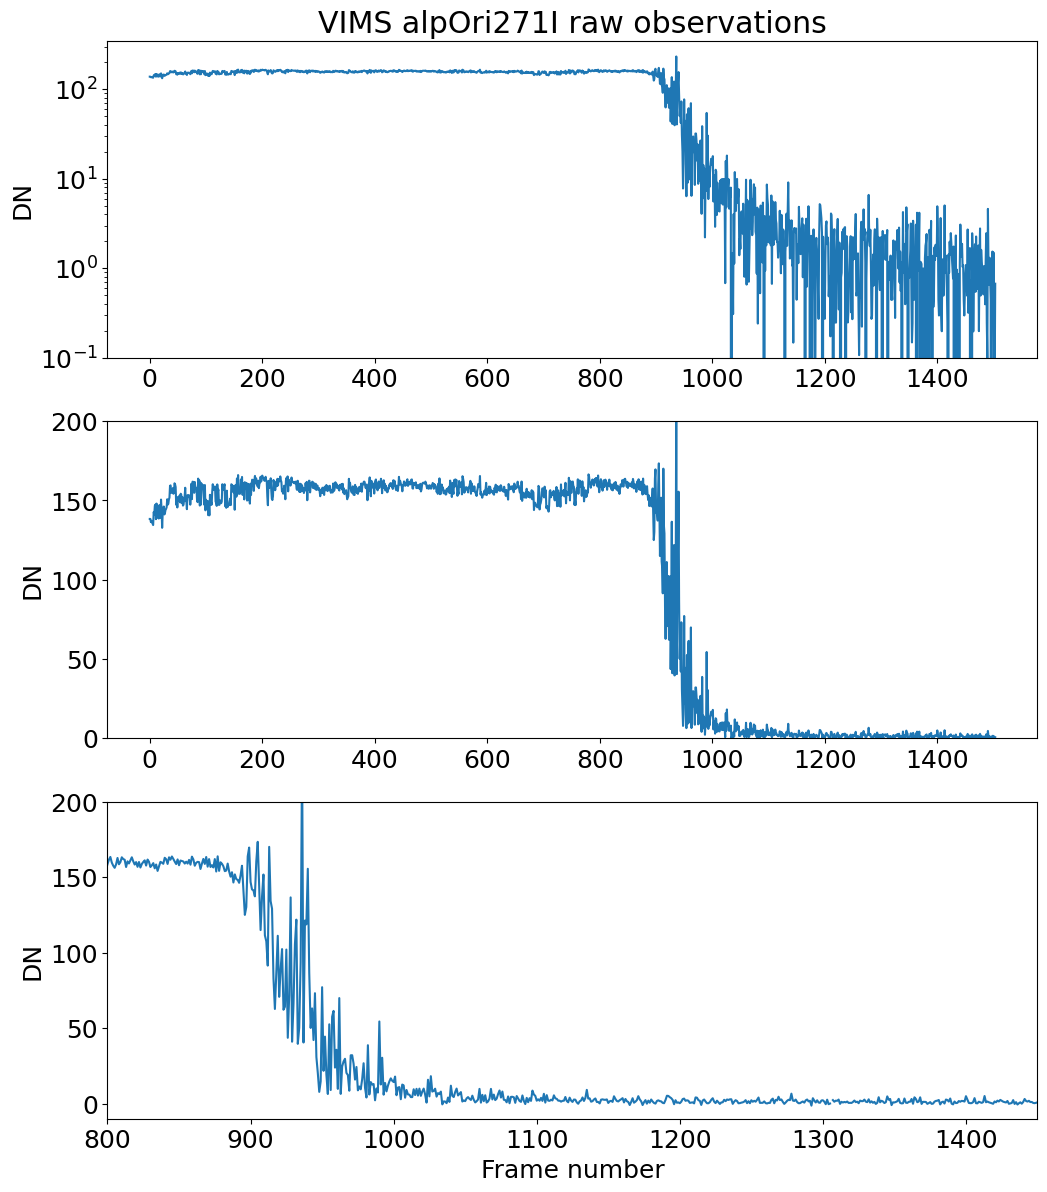

Saved ./output/VIMS alpOri271I_rawdata.jpg 

--------------Isothermal model------------------
Parameter                  Value          Stderr
H_km                      29.5256         1.7366
t_hl                    1559.9046         1.8103
y_bkg                      0.0000         0.0000
y_scale                  158.0188         1.6116
-------------------Band model 1-----------------
Parameter                  Value          Stderr
H_km                      48.4420         5.6023
t_hl                    1577.7694         6.1565
y_bkg                      0.0000         0.0000
y_scale                  160.4330         1.7819
tau_hl                     0.2164         0.0821
tau_gamma                  0.0000         0.0000
-------------------Band model 2-----------------
Parameter                  Value          Stderr
H_km                      46.8084         3.9394
t_hl                    1597.0443         8.8826
y_bkg                      0.0000         0.0000
y_scale                 

<Figure size 640x480 with 0 Axes>

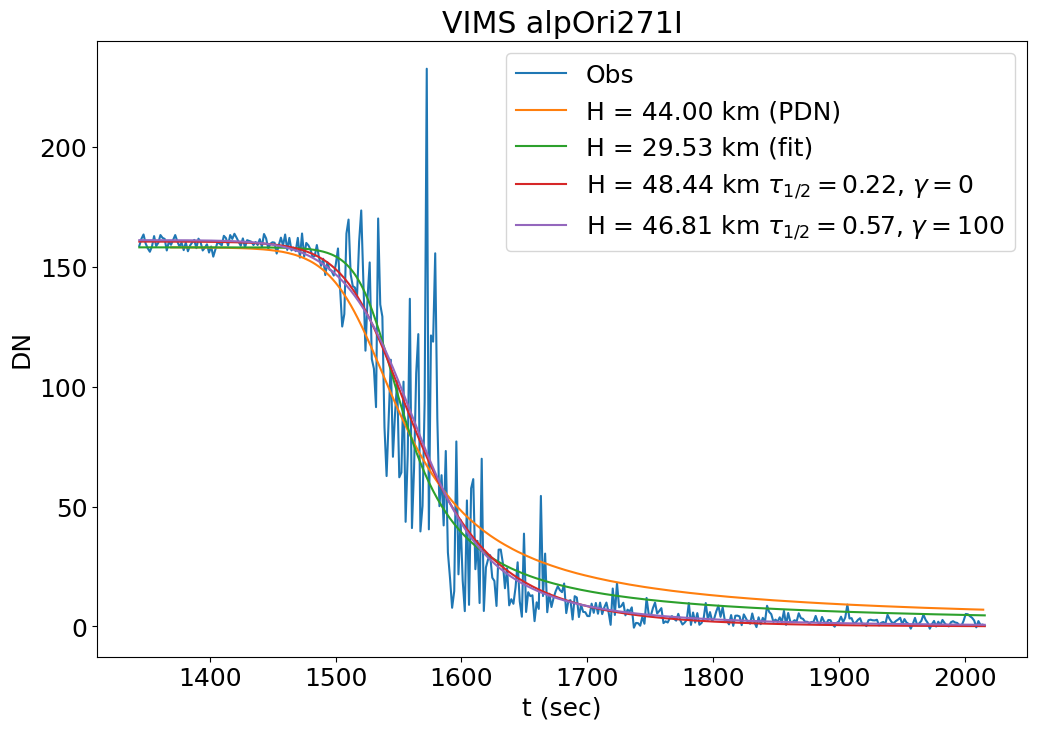

Saved ./output/VIMS alpOri271I_isofits.jpg 



<Figure size 640x480 with 0 Axes>

In [2]:
infile = VIMS['path2inputfiles'] + VIMS['VIMS_observed_lightcurve']
figfile_rawdata = VIMS['path2outputfiles'] + VIMS['event']+'_rawdata.jpg'

counts = plot_VIMS_data(infile,figfile_rawdata)

figfile_isofits = VIMS['path2outputfiles'] + VIMS['event']+'_isofits.jpg'
figfile_isofits_CIRS = VIMS['path2outputfiles'] + VIMS['event']+'_isofits_CIRS.jpg'

tsec,data,model_iso,fitted_params,model_tau,fitted_params_tau = plot_isofits(VIMS,counts,figfile_isofits)

# Load CIRS data and construct T(P) profile

dH= 0.02  in scale heights
Deepest pressure level P0_mb= 2752.9373374100487


/tmp/ipykernel_533643/158314935.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_lat = int(index_lat[0])
/tmp/ipykernel_533643/158314935.py:39: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index_JD = int(index_JD[0])



Pmbar at 0 altitude from method_lnPofhkm: 0.43329126148332014 mbar
Compared to phalf_mbar.value 2.3879225053743665 

Compute half-light nden:  2.2533064721286676e+16 1 / cm3 1.2968433102469112e+17 1 / cm3
index,half-light altitude from number density = [279] [-62.26318281] km
3.3741040881598464e-14 0.0006873755583793674
3.3741040881598464e-14 0.0006873755583793674
index,half-light altitude from refractivity = [279] [-62.26318281] km
from odeint, pred: Phalf =  [2.14633839] 2.387922505374367 mbar
Refractivity at zero altitude [1.21589141e-07]
predicted flux at upper range of CIRS data= 0.965154682781798
predicted flux at lower range of VIMS data= 0.0017318135334713684


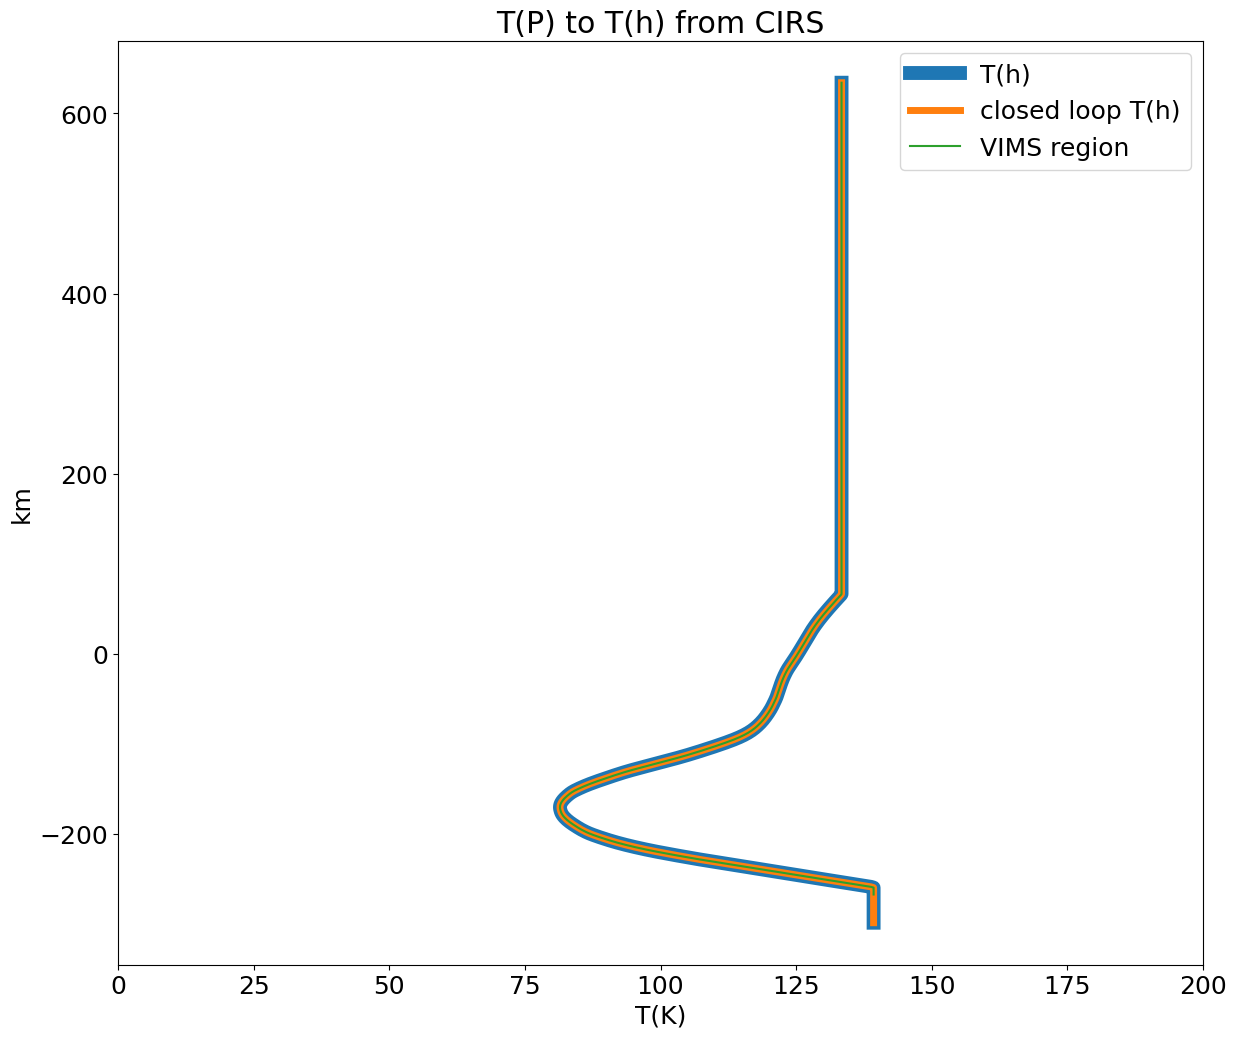

In [3]:
Isothermal = False

Hhat = 50 # points per scale height
#Hhat = 100 # points per scale height
#Hhat = 200 # points per scale height
#Hhat = 300 # points per scale height
#Hhat = 500 # points per scale height
Ha = 15.
Hb = 7.05
dh_bin_sec = 0.01*u.s
# dh_bin_sec = 0.02*u.s
# dh_bin_sec = 0.1*u.s
dh_bin_km = dh_bin_sec * abs(VIMS['vperp'])

bin_km = dh_bin_km

# get CIRS profile

IDL = readsav(VIMS['path2inputfiles']+VIMS['CIRS_TPprofiles'])
CIRS_Tarray = IDL['finaltemp']
CIRS_pmbar = IDL['press']*1e3 * u.mbar
CIRS_lat_list = IDL['newlat'] * u.deg
CIRS_JD_list = IDL['newdays']

VIMSlat_deg = VIMS['lat_c']
spice.furnsh(VIMS['path2kernels']+VIMS['tlsfile'])
VIMSUTC = VIMS['UTC']
VIMSETsec = spice.str2et(VIMSUTC)
VIMSJDocc = spice.j2000() + VIMSETsec/spice.spd()

JD = VIMSJDocc            

dlat_deg = abs(VIMSlat_deg-CIRS_lat_list)
index_lat = np.where(dlat_deg == min(dlat_deg))
index_lat = int(index_lat[0])

dJD = abs(JD - CIRS_JD_list)
index_JD = np.where(dJD== min(dJD))
index_JD = int(index_JD[0])

CIRS_T = CIRS_Tarray[index_JD,index_lat,:]*u.K

index = np.where(CIRS_T > 50*u.K)
CIRS_Tindex = CIRS_T[index]
CIRS_pmbarindex = CIRS_pmbar[index]

fill_Thigh_P= CIRS_Tindex[0]
fill_Tlow_P = CIRS_Tindex[-1]
fill_Tbelow = CIRS_Tindex[0]
fill_Tabove = CIRS_Tindex[-1]

if Isothermal == True:
    H_km = VIMS['H_km']
    T_VIMS = HtoT(VIMS['g_ms2'],VIMS['mu'],H_km)
    method_TofPmbar= interp1d(CIRS_pmbarindex,CIRS_Tindex*0+T_VIMS,'cubic',bounds_error=False,
        fill_value = (T_VIMS,T_VIMS))
    method_ToflogPmbar= interp1d(np.log(CIRS_pmbarindex.value),CIRS_Tindex*0 +T_VIMS,'cubic',bounds_error=False,\
        fill_value=(T_VIMS,T_VIMS))
else:
    H_km = TtoH(VIMS['g_ms2'],VIMS['mu'],fill_Tlow_P) # in km already
    method_TofPmbar= interp1d(CIRS_pmbarindex,CIRS_Tindex,'cubic',bounds_error=False,
       fill_value=(fill_Tlow_P,fill_Thigh_P))
    method_ToflogPmbar= interp1d(np.log(CIRS_pmbarindex.value),CIRS_Tindex,'cubic',bounds_error=False,\
       fill_value=(fill_Tlow_P,fill_Thigh_P))

Haphb = Ha + Hb
NH = int(Hhat*Haphb)
imax = NH
dH = 1.0/Hhat
print('dH=',dH,' in scale heights')
Hvals = -Hb + np.linspace(0,NH-1,NH)*dH # this is positive upward

Hkm = H_km.value
hvalskm = Hvals * H_km # array of altitudes in km
hvalskm_ = hvalskm.value

g = VIMS['g_ms2'].to('km/s**2')
Losch = (2.6867811e25/u.m**3).to('1/km**3')
RSTP = VIMS['RSTP']
mu = VIMS['mu'] 
R_curv = VIMS['r_curv']
N_A = const.N_A
D_km = VIMS['range']

denfac0 = 2*Losch/(np.pi*np.sqrt(2*R_curv)*RSTP)
denfac = denfac0 * bin_km**1.5 * 2/(3*D_km) # number density /km^3
denfac_cgs = denfac.to(1/u.cm**3)
den_halflight = (denfac0*H_km**1.5/D_km).to(1/u.cm**3)*np.sqrt(np.pi)/2

prfac0 = 4*g*mu*Losch/(3*np.pi*np.sqrt(2*R_curv)*RSTP*N_A)
prfac  = prfac0 * bin_km**2.5 * 2/(5*D_km)
prfac_mbar = prfac.to(u.mbar)
phalf_mbar = (prfac0 * H_km**2.5/D_km * 3 * np.sqrt(np.pi)/4).to(u.mbar) 

dhkm = hvalskm[1]-hvalskm[0]

#specify initial condition (boundary condition )

Pmbar_initial = phalf_mbar.value * np.exp(Hb) 
P0_mb = Pmbar_initial

print('Deepest pressure level P0_mb=',P0_mb)
g_kms2 = VIMS['g_ms2'].to('km/s**2')
lnPmbarinitial = np.log(Pmbar_initial)

lnPsolution = odeint(lnbarometric, lnPmbarinitial, hvalskm,args=(method_TofPmbar,mu,g_kms2),rtol=1e-12) 
lnPodeint = lnPsolution[:,0] # Pressure as a function of height
Podeint = np.exp(lnPodeint)

lnPsolution2 = odeint(lnbarometric2, lnPmbarinitial, hvalskm_,args=(method_ToflogPmbar,mu,g_kms2),rtol=1e-12)
lnPodeint2 = lnPsolution2[:,0] # Pressure as a function of height
Podeint2 = np.exp(lnPodeint2)

Tofh = method_TofPmbar(Podeint)
Pofh = Podeint

Tofh2 = method_ToflogPmbar(lnPodeint2)
Pofh2 = Podeint2

if Isothermal == True:
    fill_value=(T_VIMS,T_VIMS)
else:
    fill_value=(fill_Tlow_P,fill_Thigh_P)
    
method_Tofhkm = interp1d(hvalskm_,Tofh,bounds_error=False,
    fill_value=fill_value)

method_Pofhkm= interp1d(hvalskm_,Podeint,bounds_error=False)

method_lnPofhkm= interp1d(hvalskm_,lnPodeint,bounds_error=False)

method_hkmofPmbar= interp1d(Podeint,hvalskm_,bounds_error=False)

method_hkmoflnPmbar= interp1d(lnPodeint,hvalskm_,bounds_error=False)

testTofh = method_TofPmbar(method_Pofhkm(hvalskm_))

testTofh2 = method_ToflogPmbar(method_lnPofhkm(hvalskm_))

# confirm that starting Podeint is our intial value
# print(Pofh[0],Pmbar_initial)

# compute number density and then refractivy
nofh = (Pofh*u.mbar/(const.k_B * Tofh*u.K)).to("1/cm**3")
# print("min,max nofh=",min(nofh),max(nofh))
# print("min,max Pofh=",min(Pofh),max(Pofh))
# print("min,max Tofh=",min(Tofh),max(Tofh))
Nofh = nofh *RSTP/Losch.to('1/cm**3')

T_new = method_TofPmbar(Pmbar_initial)*u.K
P_new = np.exp(method_lnPofhkm(0))*u.mbar

print("\nPmbar at 0 altitude from method_lnPofhkm:",P_new)
print("Compared to phalf_mbar.value",phalf_mbar.value,'\n')

n_new = (P_new/(const.k_B * T_new)).to("1/cm**3")
print('Compute half-light nden: ',n_new,den_halflight)

nofh_new = (Pofh*u.mbar/(const.k_B * Tofh*u.K)).to("1/cm**3")
dnofh = abs(nofh_new - den_halflight)
index = np.where(dnofh == min(dnofh))[0]

h0 = hvalskm[index]
print('index,half-light altitude from number density =',index,h0)
#determine altitude where Nofh is closest to half light pred value
print(min(Nofh),max(Nofh))
Nofh_new = nofh_new * RSTP / Losch.to('1/cm**3')

H_km_VIMS = H_km

fig1=plt.figure(figsize=(14,12)) # open up figure 

nhalf_pred = (Losch * H_km_VIMS**1.5/(np.sqrt(2*np.pi*R_curv)*D_km*RSTP)).to(1/u.cm**3)
Nhalf_pred = (nhalf_pred * VIMS['RSTP']/Losch.to('1/cm**3')).value
phalf_pred = (nhalf_pred * H_km_VIMS * mu * g_kms2 * 1/N_A).to(u.mbar)

print(min(Nofh_new),max(Nofh_new))
dNofh = abs(Nofh_new.value-Nhalf_pred)
index = np.where(dNofh == min(dNofh))[0]
h0 = hvalskm[index]
print('index,half-light altitude from refractivity =',index,h0)
Phalf_odeint = Pofh[index]
print("from odeint, pred: Phalf = ",Phalf_odeint,phalf_pred)

# refractivity at hvalskm of 0
l=np.where(np.abs(hvalskm) == min(np.abs(hvalskm)))
Nofh_new_0km = Nofh_new[l]
print('Refractivity at zero altitude',Nofh_new_0km)

VIMS_Pmbar_max = Pmbar_initial*.5*u.mbar # placeholdeer
index = np.where(hvalskm_ > method_hkmofPmbar(VIMS_Pmbar_max))
hvals_ = hvalskm[index]
xvals = method_Tofhkm(hvals_.value)
#print('xvals=',xvals)
#print('hvals=',hvals)
fig1=plt.figure(1,figsize=(10,6)) # open up figure 
plt.rcParams.update({'font.size': 18})
plt.plot(Tofh,hvalskm_,linewidth=10,label='T(h)')
plt.plot(testTofh,hvalskm_,linewidth=5,label='closed loop T(h)')

plt.plot(xvals,hvals_,label='VIMS region')
plt.xlim(0,200)
plt.xlabel('T(K)')
plt.ylabel('km')
#plt.ylim(200,600)
plt.title('T(P) to T(h) from CIRS')
plt.legend()

# now try predicting flux level at top of CIRS data
phi_upper = 1/(1+min(CIRS_pmbarindex)/phalf_pred)
phi_lower = 1/(1+VIMS_Pmbar_max/phalf_pred)
print('predicted flux at upper range of CIRS data=',phi_upper)
print('predicted flux at lower range of VIMS data=',phi_lower)

# Construct synthetic lightcurve based on CIRS T(P) and refractivity

In [4]:
print('Computing lightcurve...')
Rt = hvalskm + VIMS['r_curv']
R_in = Rt
nu_in = Nofh_new
rho2,theta2,phi_cyl2 = pro_lcgen_v2(R_in,nu_in,VIMS['range'])
print('Finished computing lightcurve')

Computing lightcurve...
flipping input R array
flipping input nu array
First ten elements of R, nu: R should decrease, nu should increase
[66677.56792294 66676.7208048  66675.87368667 66675.02656854
 66674.1794504  66673.33233227 66672.48521414 66671.638096
 66670.79097787 66669.94385974]
[3.37410409e-14 3.44226551e-14 3.51180389e-14 3.58274703e-14
 3.65512332e-14 3.72896171e-14 3.80429174e-14 3.88114353e-14
 3.95954783e-14 4.03953600e-14]
len(R),len(nu) 1102 1102
R array is in the correct order
nu array is in the correct order
Finished computing lightcurve


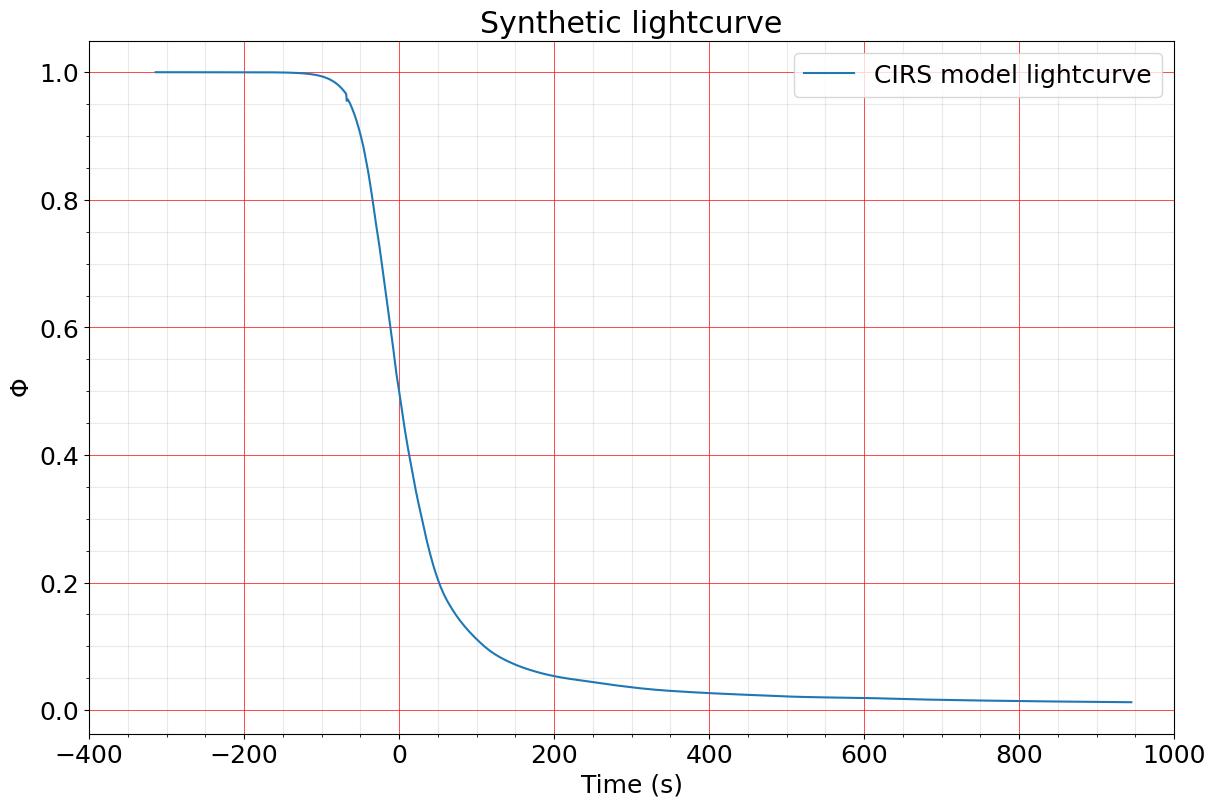

In [5]:
offset2 = 0*u.s
xvals2 = -(-np.array(rho2,dtype=float)*u.km+VIMS['r_curv'])/VIMS['vperp'] + offset2
xvals2[0] = xvals2[1] - (xvals2[2]-xvals2[1])
tscale = xvals2
L = np.where(tscale < 1000*u.s)
tscale = tscale[L]
flux = phi_cyl2[L]
dt_interp = 0.1*u.s

start = np.ceil(tscale[0]) 
stop = np.floor(tscale[-1] )
Npts = int((stop-start)/dt_interp +1)

t_interpol = np.linspace(start,stop,Npts,endpoint=True)
f_interpol = interp1d(tscale,flux,kind='linear')
flux_interpol = f_interpol(t_interpol)

L = np.min(np.where(flux_interpol <= 0.5))
t_half = t_interpol[L]

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

plt.plot(t_interpol-t_half,flux_interpol,label='CIRS model lightcurve')
plt.xlabel('Time (s)')
plt.ylabel(r'$\Phi$')
plt.title('Synthetic lightcurve')
plt.legend()
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlim(-400,1000)
plt.show()

# Invert synthetic lightcurve to confirm retrieval agrees with input T(P)

In [6]:
D_in = VIMS['range']
nu_in0 = 0.
nu2,theta2,R2 = pro_lcinvert(rho2,phi_cyl2,nu_in0,D_in)


ncm3_2a,den_2a,Pmbar_2a,T2a,H2a = \
    pro_refrac2profile(R2*u.km,nu2,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])


1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

# Overplot CIRS model lightcurve on isofit/isotau VIMS observations

--------------Isothermal model------------------
Parameter                  Value          Stderr
H_km                      29.5256         1.7366
t_hl                    1559.9046         1.8103
y_bkg                      0.0000         0.0000
y_scale                  158.0188         1.6116
-------------------Band model 1-----------------
Parameter                  Value          Stderr
H_km                      48.4420         5.6023
t_hl                    1577.7694         6.1565
y_bkg                      0.0000         0.0000
y_scale                  160.4330         1.7819
tau_hl                     0.2164         0.0821
tau_gamma                  0.0000         0.0000
-------------------Band model 2-----------------
Parameter                  Value          Stderr
H_km                      46.8084         3.9394
t_hl                    1597.0443         8.8826
y_bkg                      0.0000         0.0000
y_scale                  161.0295         1.8444
tau_hl              

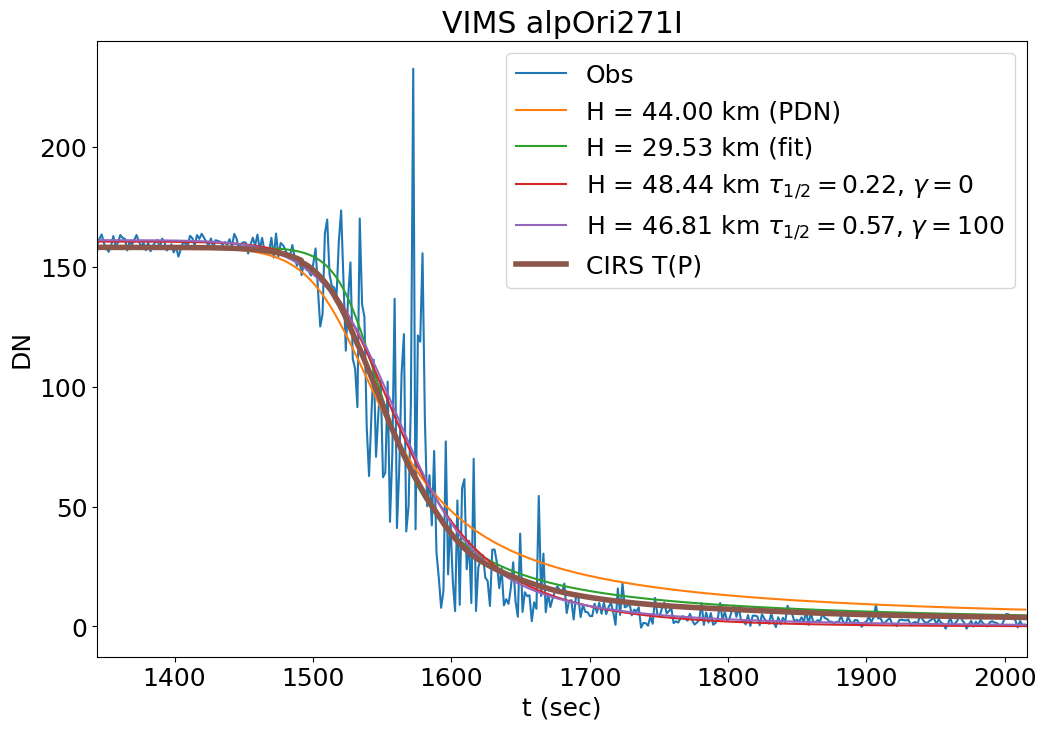

Saved ./output/VIMS alpOri271I_isofits_CIRS.jpg 



<Figure size 640x480 with 0 Axes>

In [7]:
tsec_CIRS = t_interpol-t_half
flux_CIRS = flux_interpol
plot_isofits_CIRS(VIMS,tsec_CIRS,flux_CIRS,counts,figfile_isofits_CIRS)

# Invert CIRS interpolated lightcurve to confirm it matches input T(P)

1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

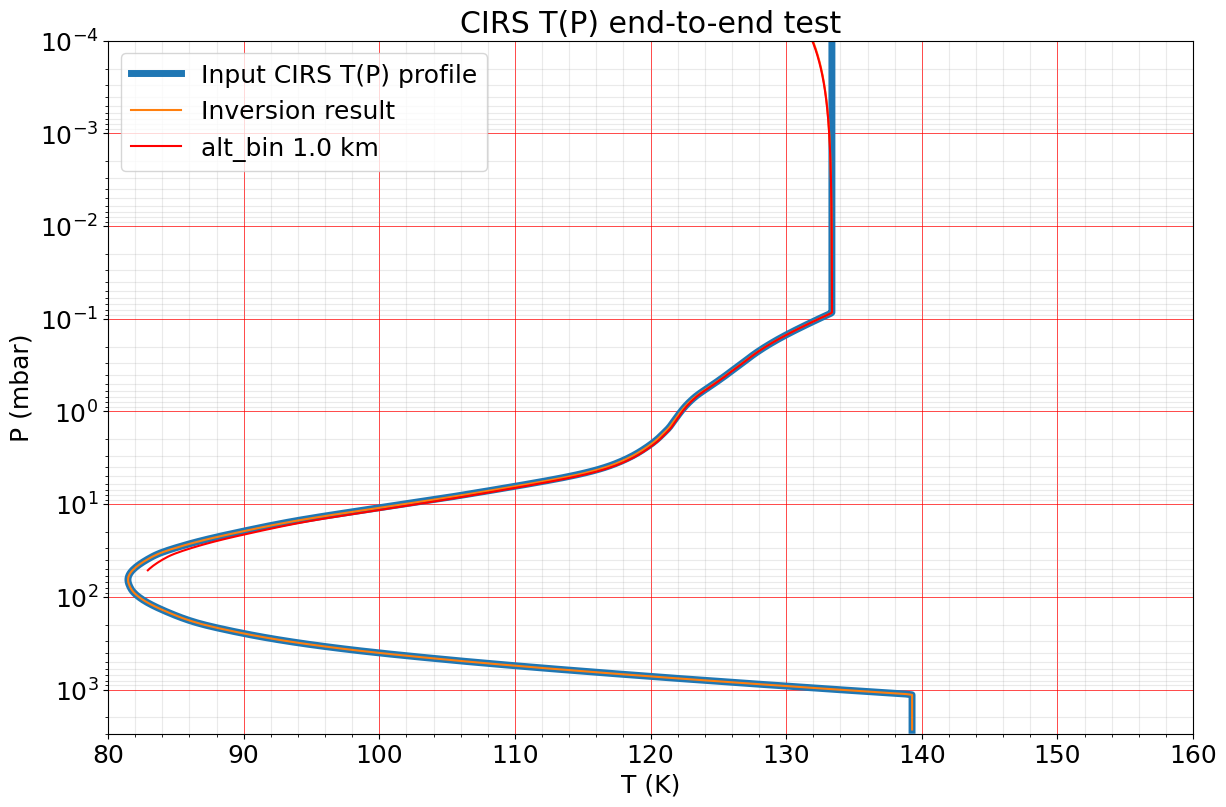

In [8]:
vperp_kms = abs(VIMS['vperp'])
Dkm = VIMS['range']
tau_hl = 0.
dh_bin_km = 1*u.km # desired altitude resolution
hakm = 400*u.km # not sure what this should be

#lightcurve to altitude-binned values

profile_flux,profile_time,profile_alt,profile_alt_theta,\
    profile_dtheta,profile_theta,i_tot = \
    alt_bin_dimensional(tsec_CIRS,flux_CIRS,dh_bin_km,hakm,vperp_kms,Dkm,tau_hl=tau_hl,Verbose=False)


# inversion to retrieve refractivity and bending angle

rho_in = (profile_time*VIMS['vperp']+VIMS['r_curv']).value
phi_cyl_in = profile_flux
nu0_in = 0.
D_in = Dkm.value

nu,theta,R = pro_lcinvert(rho_in,phi_cyl_in,nu0_in,D_in)

# conversion to physical units for vertical profile

ncm3_,den_,Pmbar_,T_,H_ = \
    pro_refrac2profile(R*u.km,nu,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])

# plot results

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 
plt.plot(Tofh,Pofh,label='Input CIRS T(P) profile',linewidth=5)

#plt.plot(T2,Pmbar_2,label='Inversion result')
plt.plot(T2a,Pmbar_2a,label='Inversion result')
plt.plot(T_,Pmbar_,color='r',label='alt_bin '+str(dh_bin_km))

plt.yscale('log')
plt.ylim(3000,.0001)
plt.xlim(80,160)
plt.ylabel('P (mbar)')
plt.xlabel('T (K)')
plt.legend()
plt.title('CIRS T(P) end-to-end test')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

# Invert isothermal model lightcurve as end-to-end test of alt-bin

1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

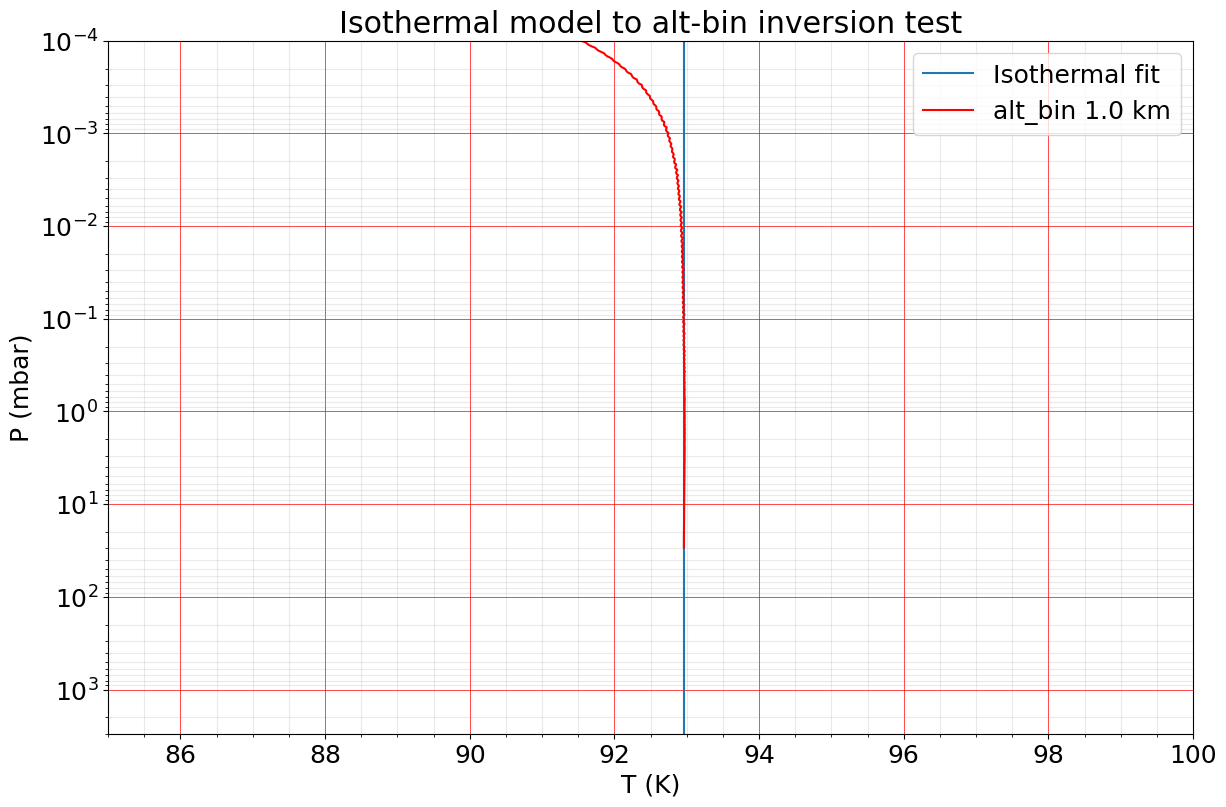

In [10]:
# Normalized flux and halflight-relative time:
t_iso = tsec-fitted_params.params['t_hl']*u.s
flux_iso = (model_iso-fitted_params.params['y_bkg'])/fitted_params.params['y_scale']

vperp_kms = abs(VIMS['vperp'])
Dkm = VIMS['range']
tau_hl = 0.
dh_bin_km = 1*u.km # desired altitude resolution
hakm = 400*u.km # not sure what this should be

#lightcurve to altitude-binned values

profile_flux,profile_time,profile_alt,profile_alt_theta,\
    profile_dtheta,profile_theta,i_tot = \
    alt_bin_dimensional(t_iso,flux_iso,dh_bin_km,hakm,vperp_kms,Dkm,tau_hl=tau_hl,Verbose=False)

# plt.plot(t_iso,flux_iso)
# plt.plot(profile_time,profile_flux)

# inversion to retrieve refractivity and bending angle

rho_in = (profile_time*VIMS['vperp']+VIMS['r_curv']).value
phi_cyl_in = profile_flux
nu0_in = 0.
D_in = Dkm.value

nu,theta,R = pro_lcinvert(rho_in,phi_cyl_in,nu0_in,D_in)
# conversion to physical units for vertical profile

ncm3_,den_,Pmbar_,T_,H_ = \
    pro_refrac2profile(R*u.km,nu,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])

# plot results

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

T_iso = HtoT(g,mu,fitted_params.params['H_km']*u.km)
plt.axvline(T_iso.value,label='Isothermal fit')

# #plt.plot(T2,Pmbar_2,label='Inversion result')
# plt.plot(T2a,Pmbar_2a,label='Inversion result')
plt.plot(T_,Pmbar_,color='r',label='alt_bin '+str(dh_bin_km))

plt.yscale('log')
plt.ylim(3000,.0001)
plt.xlim(85,100)
plt.ylabel('P (mbar)')
plt.xlabel('T (K)')
plt.legend()
plt.title('Isothermal model to alt-bin inversion test')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

# Invert isothermal tau model and compare to CIRS T(P)

1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

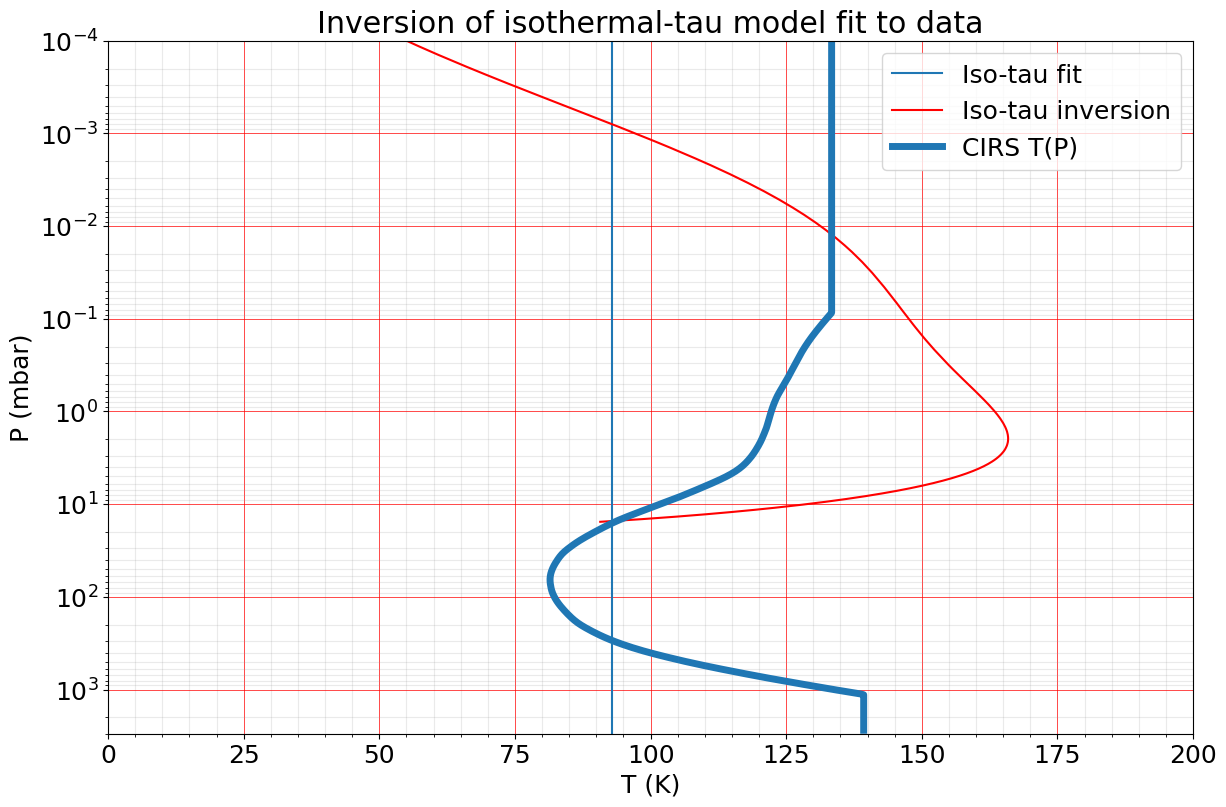

In [11]:
# Normalized flux and halflight-relative time:
t_isotau = tsec-fitted_params_tau.params['t_hl']*u.s
flux_isotau = (model_tau-fitted_params_tau.params['y_bkg'])/fitted_params_tau.params['y_scale']

vperp_kms = abs(VIMS['vperp'])
Dkm = VIMS['range']
tau_hl = 0.
dh_bin_km = 1*u.km # desired altitude resolution
hakm = 400*u.km # not sure what this should be

#lightcurve to altitude-binned values

profile_flux,profile_time,profile_alt,profile_alt_theta,\
    profile_dtheta,profile_theta,i_tot = \
    alt_bin_dimensional(t_isotau,flux_isotau,dh_bin_km,hakm,vperp_kms,Dkm,tau_hl=tau_hl,Verbose=False)

# plt.plot(t_iso,flux_iso)
# plt.plot(profile_time,profile_flux)

# inversion to retrieve refractivity and bending angle

rho_in = (profile_time*VIMS['vperp']+VIMS['r_curv']).value
phi_cyl_in = profile_flux
nu0_in = 0.
D_in = Dkm.value

nu,theta,R = pro_lcinvert(rho_in,phi_cyl_in,nu0_in,D_in)
# conversion to physical units for vertical profile

ncm3_,den_,Pmbar_,T_,H_ = \
    pro_refrac2profile(R*u.km,nu,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])

# plot results

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

T_isotau = HtoT(g,mu,fitted_params_tau.params['H_km']*u.km)
plt.axvline(T_iso.value,label='Iso-tau fit')

# #plt.plot(T2,Pmbar_2,label='Inversion result')
# plt.plot(T2a,Pmbar_2a,label='Inversion result')
plt.plot(T_,Pmbar_,color='r',label='Iso-tau inversion')
plt.plot(Tofh,Pofh,label='CIRS T(P)',linewidth=5)

plt.yscale('log')
plt.ylim(3000,.0001)
plt.xlim(0,200)
plt.ylabel('P (mbar)')
plt.xlabel('T (K)')
plt.legend()
plt.title('Inversion of isothermal-tau model fit to data')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

# Inversion of VIMS lightcurve - no isothermal cap yet

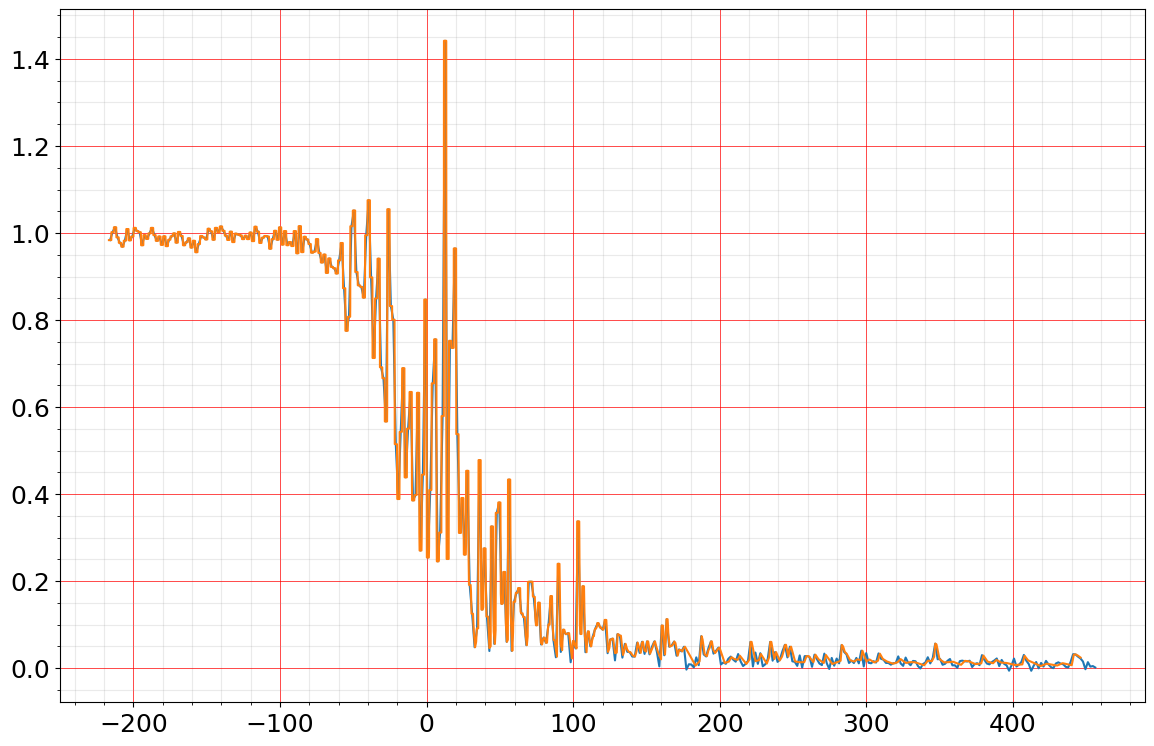

1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

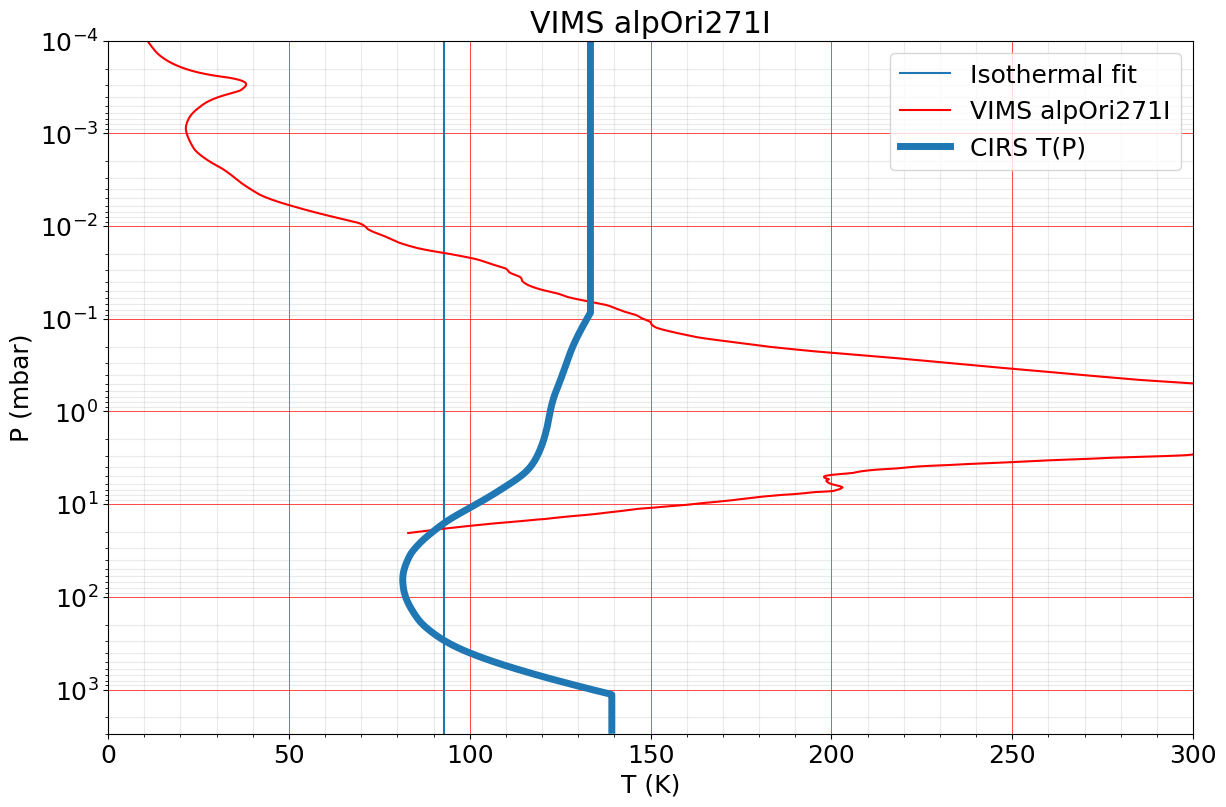

In [12]:
# Normalized flux and halflight-relative time:
t_obs = tsec-fitted_params.params['t_hl']*u.s
flux_obs = 0.98*(data-fitted_params_tau.params['y_bkg'])/fitted_params.params['y_scale']

vperp_kms = abs(VIMS['vperp'])
Dkm = VIMS['range']
tau_hl = 0.
dh_bin_km = 0.1*u.km # desired altitude resolution
hakm = 200*u.km 

#lightcurve to altitude-binned values

profile_flux,profile_time,profile_alt,profile_alt_theta,\
    profile_dtheta,profile_theta,i_tot = \
    alt_bin_dimensional(t_obs,flux_obs,dh_bin_km,hakm,vperp_kms,Dkm,tau_hl=tau_hl,Verbose=False)

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

plt.plot(t_obs,flux_obs)
plt.plot(profile_time,profile_flux)
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()
# inversion to retrieve refractivity and bending angle

rho_in = (profile_time*VIMS['vperp']+VIMS['r_curv']).value
phi_cyl_in = profile_flux
nu0_in = 0.
D_in = Dkm.value

nu,theta,R = pro_lcinvert(rho_in,phi_cyl_in,nu0_in,D_in)
# conversion to physical units for vertical profile

ncm3_obs,den_obs,Pmbar_obs,T_obs,H_obs = \
    pro_refrac2profile(R*u.km,nu,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])

# plot results

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

T_iso = HtoT(g,mu,fitted_params.params['H_km']*u.km)
plt.axvline(T_iso.value,label='Isothermal fit')


plt.plot(T_obs,Pmbar_obs,color='r',label=VIMS['event'])
plt.plot(Tofh,Pofh,label='CIRS T(P)',linewidth=5)

plt.yscale('log')
plt.ylim(3000,.0001)
plt.xlim(0,300)
plt.ylabel('P (mbar)')
plt.xlabel('T (K)')
plt.legend()
plt.title(VIMS['event'])
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

# isothermal cap

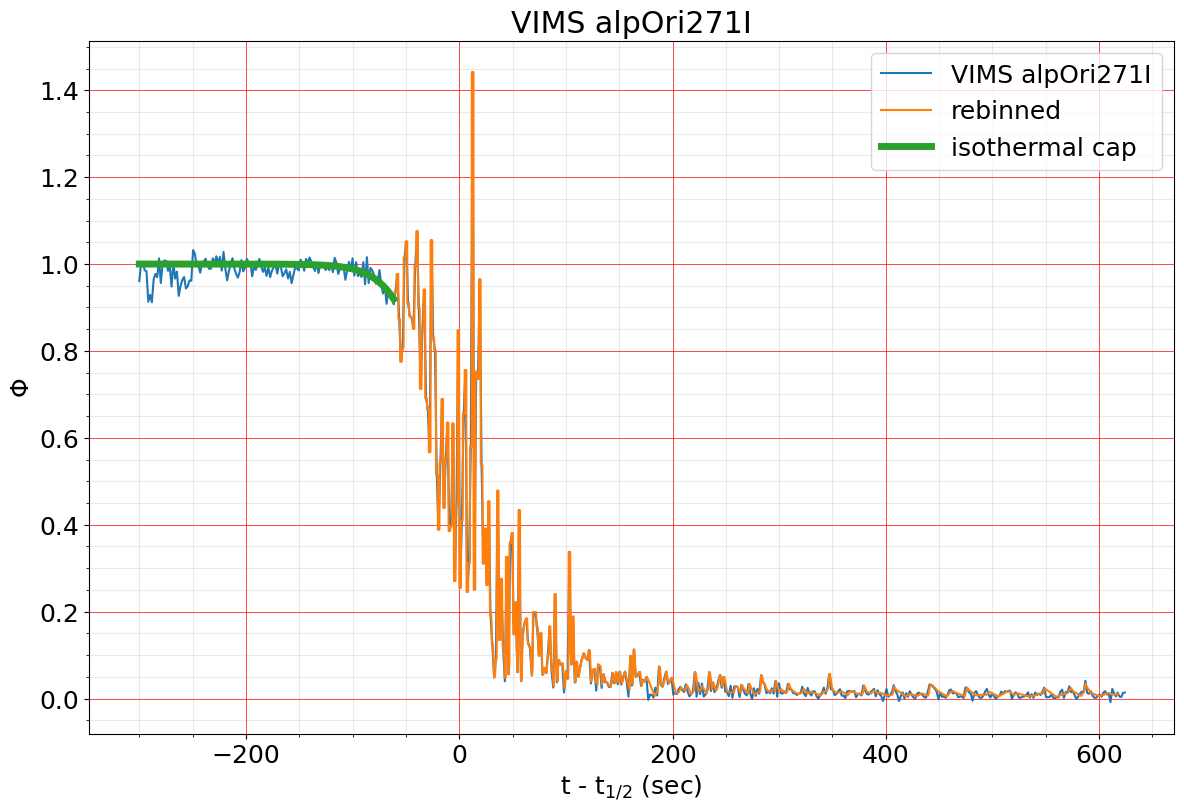

1\r2\r3\r4\r5\r6\r7\r8\r9\r10\r11\r12\r13\r14\r15\r16\r17\r18\r19\r20\r21\r22\r23\r24\r25\r26\r27\r28\r29\r30\r31\r32\r33\r34\r35\r36\r37\r38\r39\r40\r41\r42\r43\r44\r45\r46\r47\r48\r49\r50\r51\r52\r53\r54\r55\r56\r57\r58\r59\r60\r61\r62\r63\r64\r65\r66\r67\r68\r69\r70\r71\r72\r73\r74\r75\r76\r77\r78\r79\r80\r81\r82\r83\r84\r85\r86\r87\r88\r89\r90\r91\r92\r93\r94\r95\r96\r97\r98\r99\r100\r101\r102\r103\r104\r105\r106\r107\r108\r109\r110\r111\r112\r113\r114\r115\r116\r117\r118\r119\r120\r121\r122\r123\r124\r125\r126\r127\r128\r129\r130\r131\r132\r133\r134\r135\r136\r137\r138\r139\r140\r141\r142\r143\r144\r145\r146\r147\r148\r149\r150\r151\r152\r153\r154\r155\r156\r157\r158\r159\r160\r161\r162\r163\r164\r165\r166\r167\r168\r169\r170\r171\r172\r173\r174\r175\r176\r177\r178\r179\r180\r181\r182\r183\r184\r185\r186\r187\r188\r189\r190\r191\r192\r193\r194\r195\r196\r197\r198\r199\r200\r201\r202\r203\r204\r205\r206\r207\r208\r209\r210\r211\r212\r213\r214\r215\r216\r217\r218\r219\r220\r221\r222

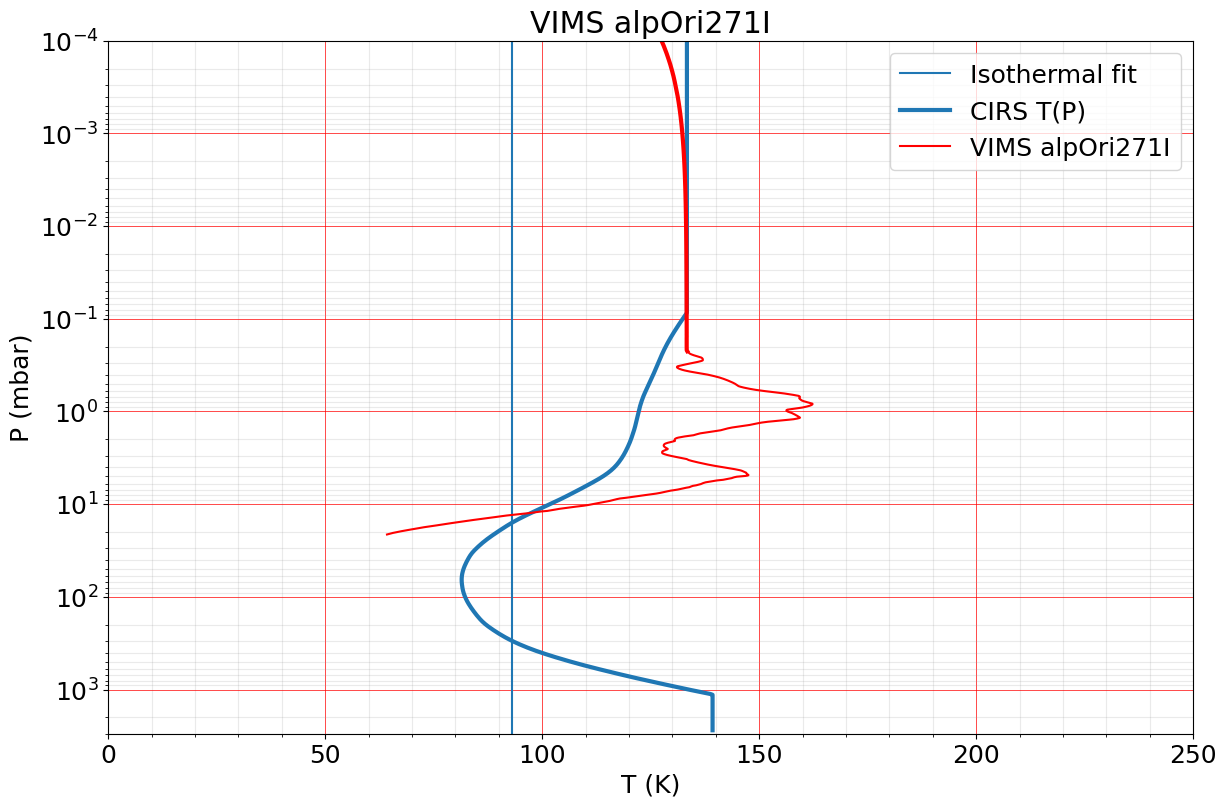

<Figure size 640x480 with 0 Axes>

In [13]:
frame = np.linspace(0,len(counts)-1,len(counts))    
L = np.where((frame >= 700) & (frame <= 1400)) # zoom specification
L = np.where((frame >= 750) & (frame <= 1300)) # zoom specification
tsec_all = frame[L]*VIMS['t_cube'] # time in sec from start of data
data_all = counts[L] # the observed lightcurve

# Normalized flux and halflight-relative time:
t_obs = tsec_all-fitted_params.params['t_hl']*u.s
flux_obs = 0.98*(data_all-fitted_params_tau.params['y_bkg'])/fitted_params.params['y_scale']
temp = 0.98*(data_all-fitted_params_tau.params['y_bkg'])/fitted_params.params['y_scale']

L = np.where(t_obs > (-40)*u.s)
L = np.where(t_obs > (-60)*u.s)
tL = t_obs[L[0]]


H_extrap = TtoH(g,mu,Tofh[-1]*u.K)
thatextrap = t_obs[0:L[0][0]]*abs(VIMS['vperp'])/H_extrap

flux_cap = flux_obs
flux_cap[0:L[0][0]] = get_phi_vals(thatextrap)

vperp_kms = abs(VIMS['vperp'])
Dkm = VIMS['range']
tau_hl = 0.
dh_bin_km = 0.1*u.km # desired altitude resolution
hakm = 600*u.km 

#lightcurve to altitude-binned values

profile_flux,profile_time,profile_alt,profile_alt_theta,\
    profile_dtheta,profile_theta,i_tot = \
    alt_bin_dimensional(t_obs,flux_cap,dh_bin_km,hakm,vperp_kms,Dkm,tau_hl=tau_hl,Verbose=False)

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

plt.plot(t_obs,temp,label=VIMS['event'])

plt.plot(profile_time,profile_flux,label='rebinned')
plt.plot(t_obs[0:L[0][0]],flux_cap[0:L[0][0]],linewidth=5,label='isothermal cap')
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.legend()
plt.xlabel(r't - t$_{1/2}$ (sec)')
plt.ylabel(r'$\Phi$')
plt.title(VIMS['event'])
plt.show()
# inversion to retrieve refractivity and bending angle

rho_in = (profile_time*VIMS['vperp']+VIMS['r_curv']).value
phi_cyl_in = profile_flux
nu0_in = 0.
D_in = Dkm.value

nu,theta,R = pro_lcinvert(rho_in,phi_cyl_in,nu0_in,D_in)
# conversion to physical units for vertical profile

ncm3_obs,den_obs,Pmbar_obs,T_obs,H_obs = \
    pro_refrac2profile(R*u.km,nu,Tofh[-1]*u.K,VIMS['g_ms2'],VIMS['mu'],VIMS['RSTP'])

# plot results

fig,ax=plt.subplots(figsize=(14,9)) # open up figure 

T_iso = HtoT(g,mu,fitted_params.params['H_km']*u.km)
plt.axvline(T_iso.value,label='Isothermal fit')
plt.plot(Tofh,Pofh,label='CIRS T(P)',linewidth=3)
plt.plot(T_obs,Pmbar_obs,color='r',label=VIMS['event'])

L = np.where(profile_time < (-60)*u.s)
plt.plot(T_obs[L],Pmbar_obs[L],color='r',linewidth=3) # thick line for isothermal cap

plt.yscale('log')
plt.ylim(3000,.0001)
plt.xlim(0,250)
plt.ylabel('P (mbar)')
plt.xlabel('T (K)')
plt.legend()
plt.title(VIMS['event'])
ax.grid(linestyle='-', linewidth='0.5', color='red')
ax.minorticks_on()
ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

plt.show();

plt.savefig("output/TP-prof-compare.png")

In [14]:
print('All done!')

All done!
